## Linear Regression notebook

In this notebook, various linear regression (LR) models are trained.  A baseline LR model is trained on the training set with no feature engineering or feature selection.  By testing all possible feature selections, it is determined that including all features is optimal.  With feature engineering a new LR model is trained (using all features).  After many Optuna trials, it appears that including all features is, again, optimal.  The RMSLE error of these two models predicting on the testing set is: 

-No feature engineering, no feature selection: 0.17926\
-Feature engineering, feature selection: 0.09431

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import optuna
from optuna.trial import TrialState

In [17]:
train = pd.read_csv("train_pp.csv")
test = pd.read_csv("test_pp.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,36,189,82,26,101,41.0,5.017280
1,0,64,163,60,8,85,39.7,3.555348
2,0,51,161,64,7,84,39.8,3.401197
3,1,20,192,90,25,105,40.7,4.948760
4,0,38,166,61,25,102,40.6,4.990433


### Linear Regression without feature engineering

C:\Users\eblac\AppData\Local\Temp\ipykernel_19364\1331040239.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')


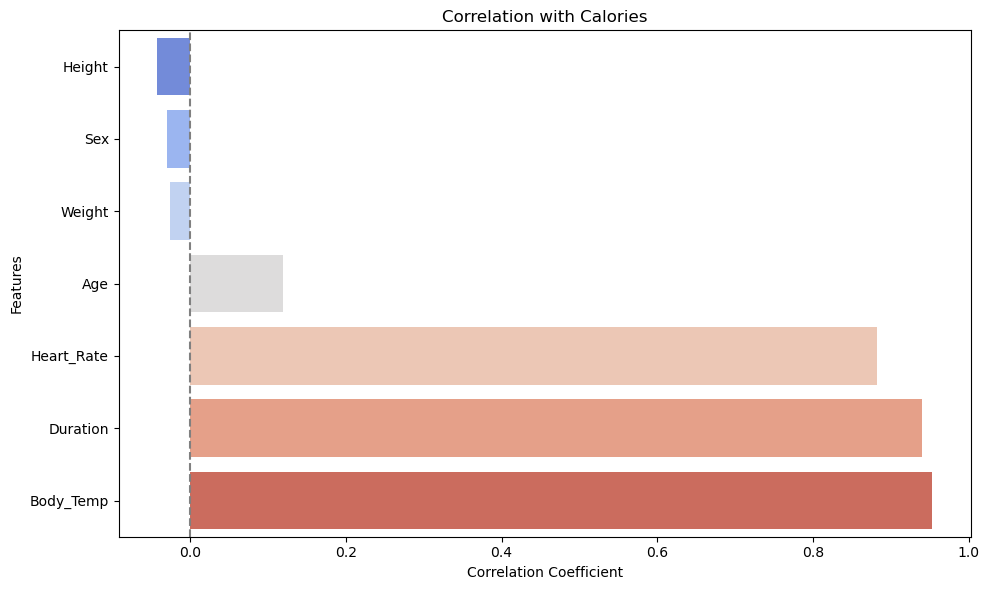

In [21]:
# Compute correlations
correlations = train.corr(numeric_only=True)['Calories'].drop('Calories').sort_values()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title('Correlation with Calories')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

Create a linear regression model using all features.

Train prediction: 0.17992357783141383
Test prediction: 0.1798668165522313


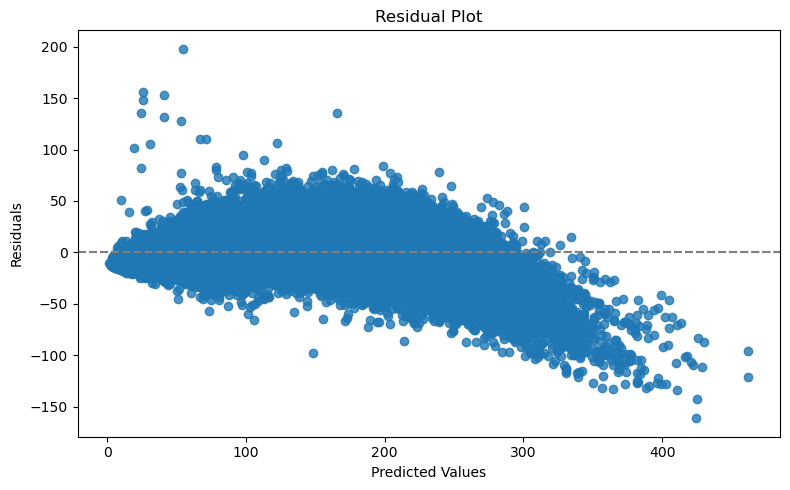

       id    Calories
0  750000   33.605100
1  750001   98.549540
2  750002   91.275697
3  750003  139.639586
4  750004   79.010833

count    250000.000000
mean         89.667098
std          69.570626
min           2.232829
25%          31.759940
50%          70.652250
75%         136.088544
max         319.949645
Name: Calories, dtype: float64


In [ ]:
# kaggle score 0.17926 private, 0.17875 public (LinReg_10.csv)

X = train.drop(columns='Calories')
y = train['Calories']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=724)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
predictions[predictions <= 0] = 0.2

# Make predictions
train_pred = model.predict(X_train)
train_pred[train_pred < 0] = 0.2

print("Train prediction:", rmse(train_pred, y_train))
print("Test prediction:", rmse(predictions, y_test))

residuals = y_test - predictions

# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(predictions), y=np.expm1(y_test))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# make the submission file!

pred = model.predict(test)
pred[pred <= 0] = 0.2

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("LinReg_10.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

### Test all possible feature combinations to get the best linear regression model (without feature engineering).

In [6]:
def powerset(s):
    ''''''''''''''''
    Input: A list s.
    Output: The powerset of s minus the empty set.
    Example: s = ['a', 'b']
    list(powerset(s)) will return [['a'], ['b'], ['a', 'b']].
    '''''''''''''''
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1, 1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]

Find the best combination of features!

In [20]:
X = train.drop(columns="Calories")
y = train['Calories']

col_combo = list(powerset(X.columns.tolist()))

err = []

for feats in col_combo:
    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=724)

    scores = []

    # Perform cross-validation manually
    for train_index, test_index in kf.split(X[feats]):
        X_train, X_val = X[feats].loc[train_index], X[feats].loc[test_index]
        y_train, y_val = y.loc[train_index], y.loc[test_index]
        
        # Train and evaluate
        model = LinearRegression()
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        
        # Calculate the score
        score = rmse(y_val, predictions)
        scores.append(score)
    

    # Calculate mean RMSLE
    err.append(np.mean(scores))


min_value = min(err) #find the min value
min_index = err.index(min_value) #find the index of the min value

print(f"Minimum value: {min_value}")
print(f"Index of minimum value: {min_index}, which corresponds to", col_combo[min_index])

Minimum value: 0.1799150623625379
Index of minimum value: 126, which corresponds to ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']


Using all features is optimal.

## Feature engineering
Add cross terms, body mass index (BMI), and Body_Temp squared

In [22]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, and Body_Temp squared
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)
    df_new['Body_Temp_-_min_sq'] = (df_new['Body_Temp']-df_new['Body_Temp'].min())**2

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            #cross_term_name = f"{feature1}_divided_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

Which features are correlated with Calories?

In [28]:
X = add_feats(train, numerical_features)
y = train['Calories']

train_FE = pd.concat([X, y], axis=1)

train_FE.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Body_Temp_-_min_sq,Age_x_Height,...,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp,Calories
0,1,36,189,82,26,101,41.0,22.955684,15.21,6804,...,4914,19089,7749.0,2132,8282,3362.0,2626,1066.0,4141.0,5.017280
1,0,64,163,60,8,85,39.7,22.582709,6.76,10432,...,1304,13855,6471.1,480,5100,2382.0,680,317.6,3374.5,3.555348
2,0,51,161,64,7,84,39.8,24.690405,7.29,8211,...,1127,13524,6407.8,448,5376,2547.2,588,278.6,3343.2,3.401197
3,1,20,192,90,25,105,40.7,24.414062,12.96,3840,...,4800,20160,7814.4,2250,9450,3663.0,2625,1017.5,4273.5,4.948760
4,0,38,166,61,25,102,40.6,22.136740,12.25,6308,...,4150,16932,6739.6,1525,6222,2476.6,2550,1015.0,4141.2,4.990433


C:\Users\eblac\AppData\Local\Temp\ipykernel_19364\2785241079.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')


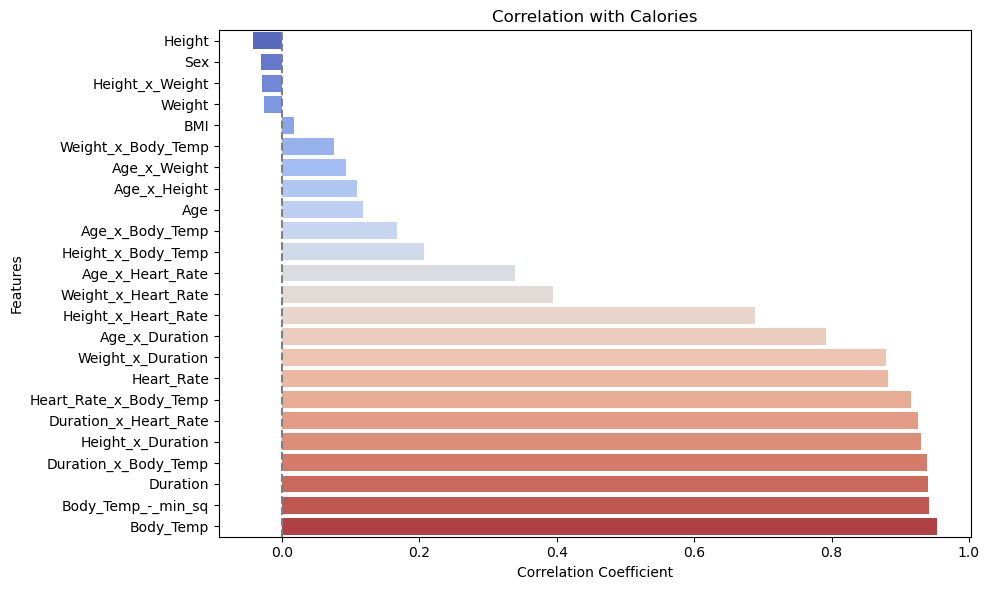

In [29]:
# Compute correlations
correlations = train_FE.corr(numeric_only=True)['Calories'].drop('Calories').sort_values()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title('Correlation with Calories')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

Train a linear regression model with all terms!

Train prediction: 0.09558229864083558
Test prediction: 0.09537100205989113


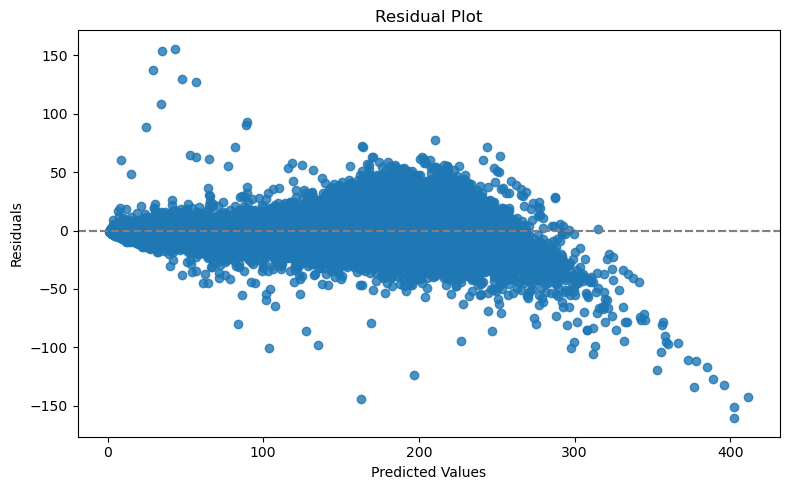

       id    Calories
0  750000   28.978311
1  750001  107.174580
2  750002   93.911978
3  750003  134.669109
4  750004   74.517431

count    250000.000000
mean         88.275188
std          62.412451
min           1.068280
25%          33.070985
50%          77.007032
75%         137.379493
max         319.949247
Name: Calories, dtype: float64


In [24]:
# kaggle score 0.09431 private, 0.09479 public (LinReg_11.csv)

X = add_feats(train, numerical_features)
y = train['Calories']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=724)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
predictions[predictions <= 0] = 1

# Make predictions
train_pred = model.predict(X_train)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmse(train_pred, y_train))
print("Test prediction:", rmse(predictions, y_test))

residuals = y_test - predictions

# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(predictions), y=np.expm1(y_test))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# make the submission file!

testsub = add_feats(test, numerical_features)

pred = model.predict(testsub)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("LinReg_11.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

## Use Optuna to select the best features.

There is a total of $2^{24}-1=16777215$ feature combinations.  There is not enough time to test all possible combinations.

In [30]:
feature_names = X.columns.tolist()

X = add_feats(train, numerical_features)
y = train['Calories']

def objective(trial):
    # Select features: binary on/off switch for each
    selected = [
        f for f in feature_names 
        if trial.suggest_categorical(f'use_{f}', [True, False])
    ]

    # ensure no duplicate trials
    for t in trial.study.trials:
        if t.state != TrialState.COMPLETE:
            continue
        if t.params == trial.params:
            # mark this trial as pruned so it won't count
            raise optuna.TrialPruned(f"duplicate of trial #{t.number}")

    # Avoid empty feature set
    if not selected:
        return float('inf')

    X_selected = X[selected]


    # Cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=724)

    scores = []

    # Perform cross-validation manually
    for train_index, test_index in kf.split(X_selected):
        X_train, X_val = X_selected.loc[train_index], X_selected.loc[test_index]
        y_train, y_val = y.loc[train_index], y.loc[test_index]
        
        # Train and evaluate
        model = make_pipeline(StandardScaler(), LinearRegression())
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        
        # Calculate the score
        score = rmse(y_val, predictions)
        scores.append(score)
    

    # Calculate mean RMSLE
    error = np.mean(scores)
    return error



# Run Optuna
# sampler = TPESampler(n_startup_trials=0, multivariate=True, group=True)
study = optuna.create_study(direction='minimize', 
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.MedianPruner(),
                            study_name='LinReg_test_log_trans',
                            storage="sqlite:///LinReg.db",
                            load_if_exists=True)
study.optimize(objective, n_trials=2000)

# Best feature subset
best_features = [f for f in feature_names if study.best_trial.params[f'use_{f}']]
print("Best RMSLE:", study.best_value)
print("Best features:", best_features)

# Feature importances (from Optuna's perspective)
# importances = optuna.importance.get_param_importances(study)
# print("Hyperparameter importances:")
# for param, imp in importances.items():
#     print(f"{param}: {imp:.4f}")

[I 2025-06-27 13:31:31,415] Using an existing study with name 'LinReg_test_log_trans' instead of creating a new one.
[I 2025-06-27 13:31:35,330] Trial 2000 finished with value: 0.09741784783529739 and parameters: {'use_Sex': False, 'use_Age': True, 'use_Height': False, 'use_Weight': True, 'use_Duration': True, 'use_Heart_Rate': True, 'use_Body_Temp': False, 'use_BMI': False, 'use_Body_Temp_-_min_sq': True, 'use_Age_x_Height': False, 'use_Age_x_Weight': True, 'use_Age_x_Duration': True, 'use_Age_x_Heart_Rate': True, 'use_Age_x_Body_Temp': True, 'use_Height_x_Weight': True, 'use_Height_x_Duration': True, 'use_Height_x_Heart_Rate': True, 'use_Height_x_Body_Temp': False, 'use_Weight_x_Duration': False, 'use_Weight_x_Heart_Rate': True, 'use_Weight_x_Body_Temp': True, 'use_Duration_x_Heart_Rate': True, 'use_Duration_x_Body_Temp': True, 'use_Heart_Rate_x_Body_Temp': True}. Best is trial 1352 with value: 0.09561305324717906.
[I 2025-06-27 13:31:37,376] Trial 2001 finished with value: 0.0978602

Best RMSLE: 0.09554775516854684
Best features: ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'Body_Temp_-_min_sq', 'Age_x_Height', 'Age_x_Weight', 'Age_x_Duration', 'Age_x_Heart_Rate', 'Age_x_Body_Temp', 'Height_x_Weight', 'Height_x_Duration', 'Height_x_Heart_Rate', 'Weight_x_Heart_Rate', 'Weight_x_Body_Temp', 'Duration_x_Heart_Rate', 'Duration_x_Body_Temp', 'Heart_Rate_x_Body_Temp']


In [12]:
optuna.delete_study(study_name='LinReg_test_log_trans', storage="sqlite:///LinReg.db")

Train prediction: 0.09558593526863314
Test prediction: 0.09536819485242634


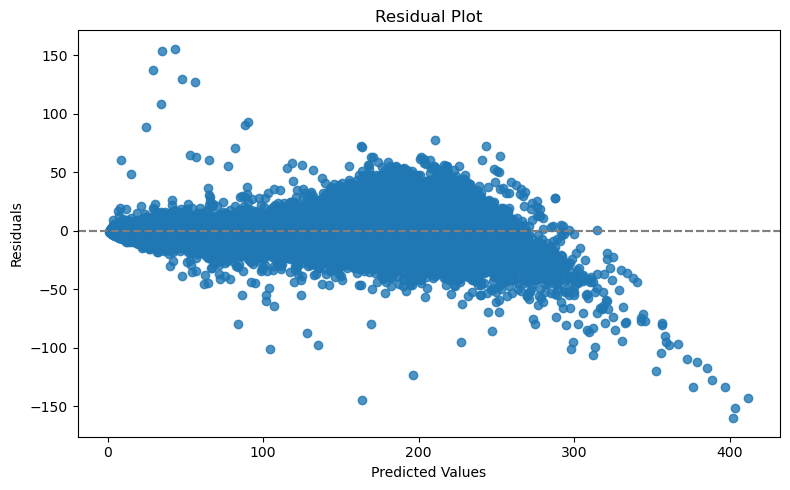

       id    Calories
0  750000   28.967994
1  750001  107.150086
2  750002   93.961249
3  750003  134.654432
4  750004   74.483019

count    250000.000000
mean         88.274942
std          62.413119
min           1.070749
25%          33.070666
50%          77.010852
75%         137.383211
max         319.574567
Name: Calories, dtype: float64


In [ ]:
# kaggle score 0.09432 private, 0.09479 public (LinReg_12.csv)

X = add_feats(train, numerical_features)
y = train['Calories']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[best_features], y, test_size=0.2, random_state=724)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)
predictions[predictions <= 0] = 1

# Make predictions
train_pred = model.predict(X_train)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmse(train_pred, y_train))
print("Test prediction:", rmse(predictions, y_test))

residuals = y_test - predictions

# Residual plot
plt.figure(figsize=(8, 5))
sns.residplot(x=np.expm1(predictions), y=np.expm1(y_test))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()



# make the submission file!

testsub = pd.get_dummies(add_feats(test, numerical_features), drop_first=True)

pred = model.predict(testsub[best_features])

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("LinReg_12.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

0.00001 worse than using all features.